In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../dataset_generator/")

import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.style.use("project_style.mplstyle")
from tqdm import tqdm
import scipy

import environments
import analysis_tools

In [3]:
if trajectories := True:
    model_type = "RNN"
else:
    model_type = "FF"
    
path = f"../models/al1_10_l2_0"
model, params = analysis_tools.load_model(path, device = "cpu", model_type = model_type) # model of interest
timesteps = 30000 # timesteps per sequence
samples = 100 # of samples for each environment

In [4]:
envs = environments.Environments()
envs = list(envs.envs) # :)

In [5]:
burn_in = 500

In [6]:
centers = np.zeros((len(envs), samples, params["outputs"], 2))

high_si_centers = []
si_masks = []
masks = []

states = np.zeros(())
for i, env in enumerate(tqdm(envs)):
    sequence = samples*[env] # sample environment several times
    x, r, v, c = analysis_tools.test_dataset(sequence, timesteps = timesteps, 
                                             context = params["context"], trajectories = trajectories)
    dataset = [((x[0][i,None], x[1][i,None]), x[1][i,None]) for i in range(len(sequence))] # repackage
    
    g, p, current_centers, preds = model.inference(dataset)
    centers[i] = current_centers
    
    mask, info = analysis_tools.spatial_information_selection(p, r, [32, 32]*len(p));
    si_masks.append(mask)
    high_si_centers.append(current_centers[:,mask])
    ###############################################
    mask = np.amin(np.amax(p[:, burn_in:], axis = -2), axis = 0) > 0
    masks.append(mask)

  0%|                                                                                      | 0/6 [00:00<?, ?it/s]/home/users/markusbp/VPC/notebooks/stats.py:73: RuntimeWarning: invalid value encountered in true_divide
  spatial_information = np.nansum(occupancy*mean_bin_rate*np.log2(mean_bin_rate/mean_rate[:,None,None]), axis = (1, 2))
/home/users/markusbp/VPC/notebooks/stats.py:73: RuntimeWarning: divide by zero encountered in log2
  spatial_information = np.nansum(occupancy*mean_bin_rate*np.log2(mean_bin_rate/mean_rate[:,None,None]), axis = (1, 2))
/home/users/markusbp/VPC/notebooks/stats.py:73: RuntimeWarning: invalid value encountered in multiply
  spatial_information = np.nansum(occupancy*mean_bin_rate*np.log2(mean_bin_rate/mean_rate[:,None,None]), axis = (1, 2))
100%|██████████████████████████████████████████████████████████████████████████| 6/6 [2:40:02<00:00, 1600.39s/it]


In [7]:
#nonzero_centers = [centers[i, np.linalg.norm(centers[i], axis=-1) > 1e-2] for i in range(len(centers))]
nonzero_centers = high_si_centers
#nonzero_centers = centers

#nonzero_centers = [centers[i,:, masks[i]] for i in range(len(centers))]
#centers[0].shape, masks[i].sum()

In [8]:
lims = np.array([-1.5, 1.5, -1.5, 1.5])*1.05
centers.shape, nonzero_centers[0].shape

((6, 100, 100, 2), (100, 36, 2))

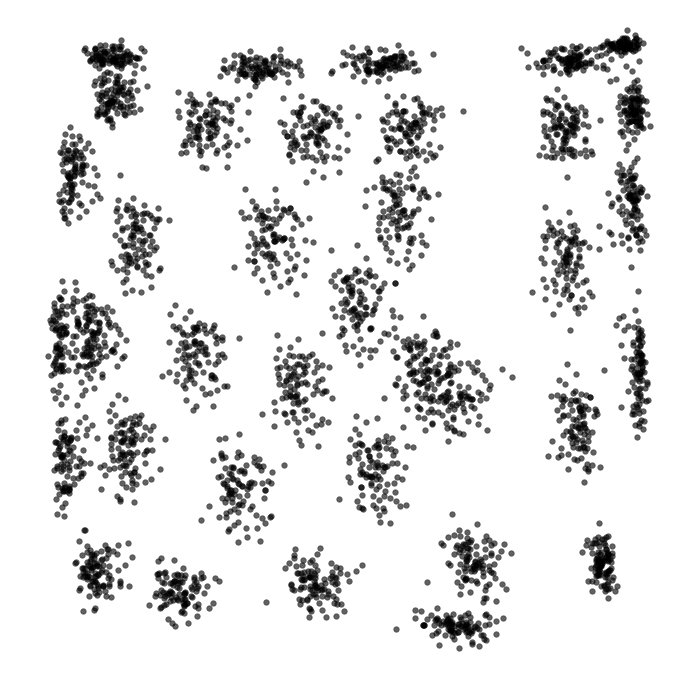

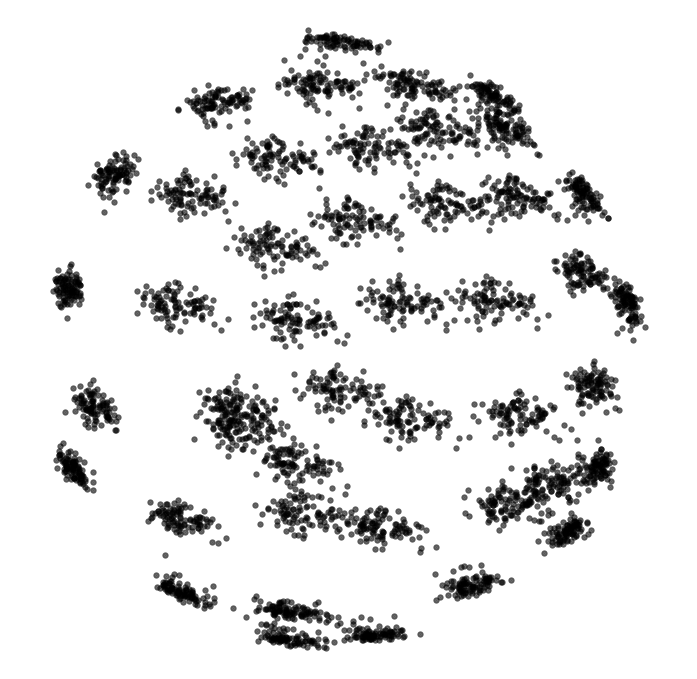

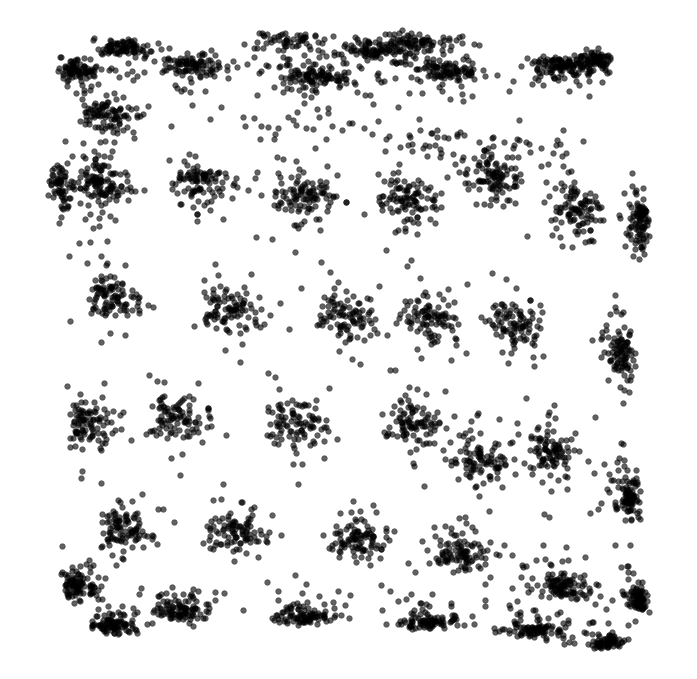

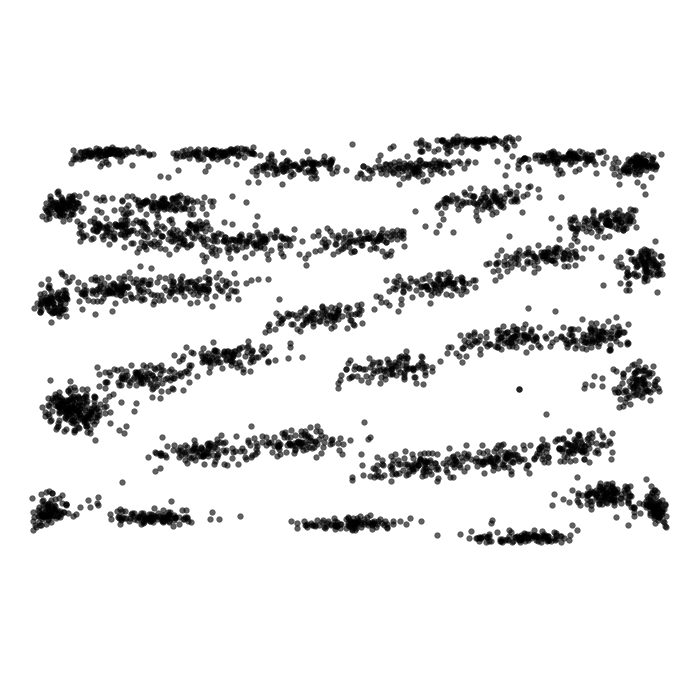

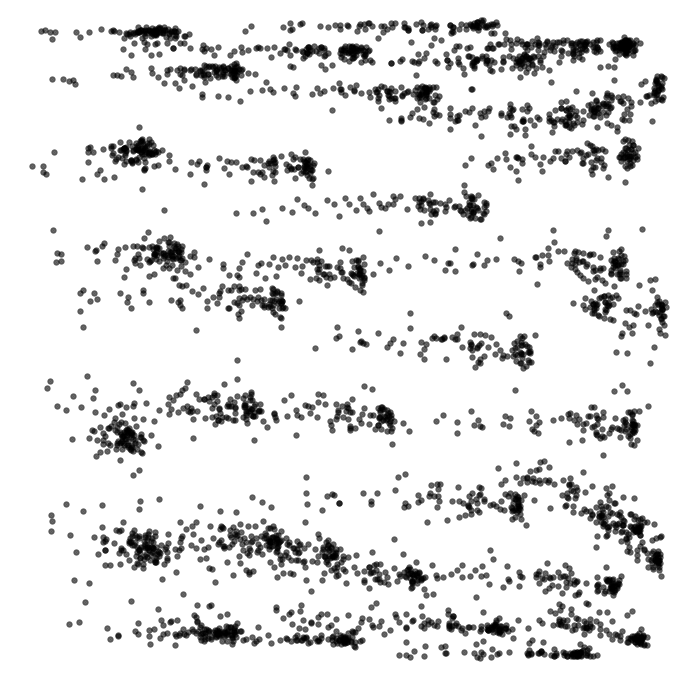

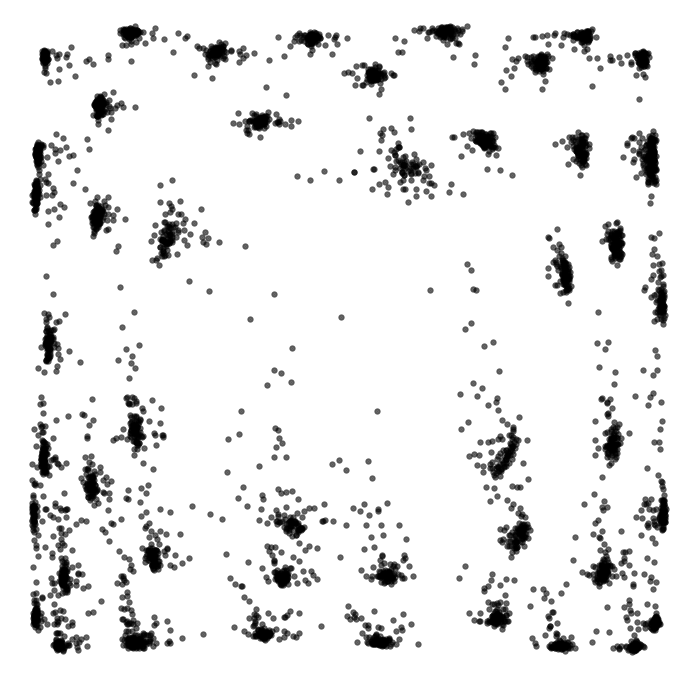

In [23]:
for i, cent in enumerate(nonzero_centers):
    plt.figure(figsize = (3,3))
    plt.plot(cent[...,0], cent[...,1], "k.", alpha = 0.65)
    plt.axis("equal")
    plt.axis("off")
    #plt.savefig(f"./figures/{envs[i]}_phases")
    plt.show()

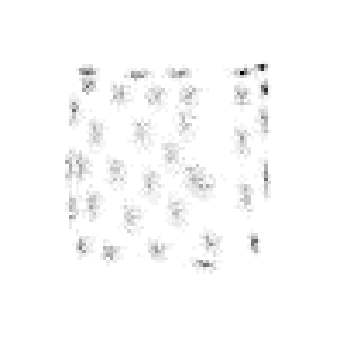

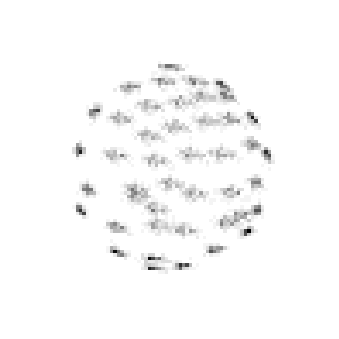

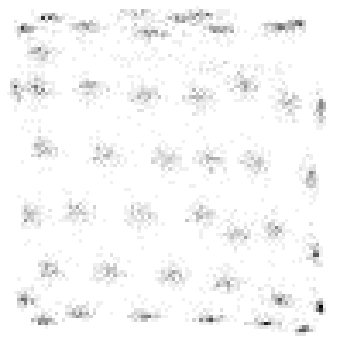

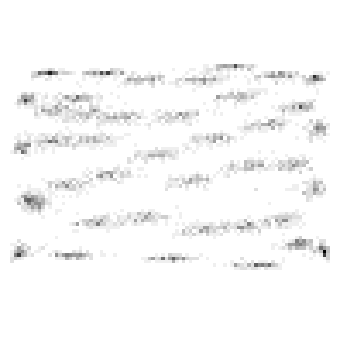

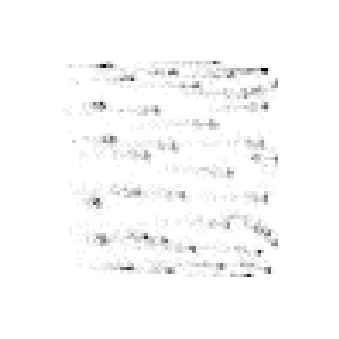

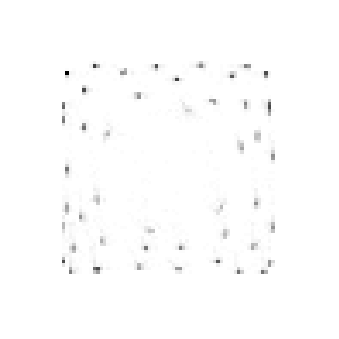

In [24]:
nr = 200
xx = np.linspace(-1.6, 1.6, nr)
lims = np.array([xx[0], xx[-1], xx[0], xx[-1]])

xx, yy = np.meshgrid(xx,xx)
r_eval = np.stack([xx.ravel(), yy.ravel()],axis=-1)

#xc = nonzero_centers[...,0].reshape(centers.shape[0], -1)
#yc = noncero_centers[...,1].reshape(centers.shape[0], -1)
bins = [np.linspace(-1.5, 1.5, 100)]*2

for i in range(len(centers)):
    xc = nonzero_centers[i][...,0].ravel()
    yc = nonzero_centers[i][...,1].ravel()

    hist = np.histogram2d(xc, yc, bins = bins)[0]
    plt.imshow(hist.T, origin = "lower", cmap = "binary")
    plt.axis("off")
    #plt.savefig(f"./figures/{envs[i]}_phases")

    plt.show()
    


In [12]:
nb = 30
lims = np.array([-1.5, 1.5, 1.5, -1.5])*2

theta_bins = np.linspace(-np.pi, np.pi, nb)
fig, ax = plt.subplots(6,6,figsize = (10,10))
for i, a in enumerate(centers):
    for j, b in enumerate(centers):
        joint_mask = (si_masks[i]*si_masks[j]).astype("bool")
        diff = b[:,joint_mask] - a[:,joint_mask]
        if i <j:
            ax[i, j % 6].plot(diff[...,0], diff[...,1], "ok", alpha = 0.1)    
            ax[i, j % 6].axis(lims)
        else:
            ax[i, j % 6].axis("off")
            
#fig.savefig(f"./figures/high_si_shifts")

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f8a3694cee0> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 3000x3000 with 36 Axes>

In [ ]:
nb = 30
lims = np.array([-1.5, 1.5, 1.5, -1.5])*2

theta_bins = np.linspace(-np.pi, np.pi, nb)
fig, ax = plt.subplots(6,6,figsize = (10,10))
for i, a in enumerate(centers):
    for j, b in enumerate(centers):
        diff = b - a
        if i <j:
            ax[i, j % 6].plot(diff[...,0], diff[...,1], "ok", alpha = 0.1)    
            ax[i, j % 6].axis(lims)
        else:
            ax[i, j % 6].axis("off")
            
#fig.savefig(f"./figures/all_shifts")


In [ ]:
nb = 30
lims = np.array([-1.5, 1.5, 1.5, -1.5])*1.1

theta_bins = np.linspace(-np.pi, np.pi, nb)
fig, ax = plt.subplots(6,6,figsize = (10,10))

def spatial_rgb(pos):
    lim = np.amax(np.abs(pos))
    
    shifted = (pos - np.amin(pos))/(np.amax(pos) - np.amin(pos))
    # scale to (0, 1)
    
    col_r = shifted[...,0]
    col_b = shifted[...,1]
    col_g = np.zeros(col_b.shape)
    rgb = np.stack((col_r, col_g, col_b), axis = -1)
    return rgb

s = 1
alpha = 0.3

for i, a in enumerate(centers):
    for j, b in enumerate(centers):

        ax[i, j % 6].axis(lims)
        ax[i, j % 6].set_aspect("equal")
        ax[i, j % 6].axis("off")
        
        colors = spatial_rgb(a)
        c = colors[:,:]
        c = c.reshape(-1, 3)
        
        if i == j:
            ax[i, j % 6].scatter(a[:,:,0].ravel(), a[:,:,1].ravel(), c = c, s = s, alpha = alpha, edgecolor = "None")

        if j % 6 > i:
            ax[i, j % 6].scatter(b[:,:,0].ravel(), b[:,:,1].ravel(), c = c, s = s, alpha = alpha, edgecolor = "None")
        #if j % 6 < i:
        #    ax[i, j % 6].scatter(a[:,joint_mask,0].ravel(), a[:,joint_mask,1].ravel(), c = c)
        
plt.subplots_adjust(wspace = 0, hspace = -0.1)
#fig.savefig(f"./figures/track_color")

In [ ]:
nb = 30
lims = np.array([-1.5, 1.5, 1.5, -1.5])*1.1

theta_bins = np.linspace(-np.pi, np.pi, nb)
fig, ax = plt.subplots(6,6,figsize = (10,10))

def spatial_rgb(pos):
    lim = np.amax(np.abs(pos))
    
    shifted = (pos - np.amin(pos))/(np.amax(pos) - np.amin(pos))
    # scale to (0, 1)
    
    col_r = shifted[...,0]
    col_b = shifted[...,1]
    col_g = np.zeros(col_b.shape)
    rgb = np.stack((col_r, col_g, col_b), axis = -1)
    return rgb

s = 2
alpha = 0.3

for i, a in enumerate(centers):
    for j, b in enumerate(centers):
        joint_mask = si_masks[i] # plot units that have high SI in a

        ax[i, j % 6].axis(lims)
        ax[i, j % 6].set_aspect("equal")
        ax[i, j % 6].axis("off")
        
        colors = spatial_rgb(a)
        c = colors[:,joint_mask]
        c = c.reshape(-1, 3)
        
        if i == j:
            ax[i, j % 6].scatter(a[:,joint_mask,0].ravel(), a[:,joint_mask,1].ravel(), c = c, s = s, alpha = alpha, edgecolor = "None")

        if j % 6 > i:
            ax[i, j % 6].scatter(b[:,joint_mask,0].ravel(), b[:,joint_mask,1].ravel(), c = c, s = s, alpha = alpha, edgecolor = "None")
        #if j % 6 < i:
        #    ax[i, j % 6].scatter(a[:,joint_mask,0].ravel(), a[:,joint_mask,1].ravel(), c = c)
        
plt.subplots_adjust(wspace = 0, hspace = -0.1)
#fig.savefig(f"./figures/track_color_high_si")


In [25]:
#np.save("./centers.npy", centers)

In [20]:
#np.save("./masks.npy", masks)

In [21]:
#np.save("./high_si_masks.npy", si_masks)